In [1]:
from Model import Model
import Parameters
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import Util

In [2]:
def moving_average_compare(data):
    return Util.moving_average(data[0,0:,:])

In [3]:
def moving_average_compare_vaccine(data, index):
    return Util.moving_average(data[index,0:,:])

In [4]:
def compute_sdd(act, predict):
    difference = act - predict
    return np.sum(np.square(difference))

In [5]:
infectiousness = 0.2
# infectiousness = 0.15
m1 = Model(forecast_days=0, infectiousness=infectiousness)
m2 = Model(forecast_days=0, infectiousness=infectiousness, prior_immunity=0)
start_date = datetime.datetime(2020, 1, 15)
m1.date = 712
#m1.date = 712?

[0.    0.    0.    0.    0.    0.001 0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.   ]
[0.    0.    0.    0.001 0.001 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.001 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.001 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.001 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.001 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.002 0.    0.001]
[0.    0.    0.001 0.002 0.003 0.003 0.002 0.001 0.001]
[0.    0.    0.001 0.002 0.003 0.004 0.003 0.001 0.001]
[0.    0.    0.002 0.003 0.004 0.004 0.003 0.001 0.002]
[0.    0.    0.002 0.003 0.004 0.005 0.003 0.001 0.003]
[0.    0.    0.002 0.004 0.005 0.005 0.004 0.001 0.003]
[0.    0.    0.003 0.005 0.006 0.006 0.004 0.002 0.004]
[0.    0.    0.004 0.006 0.007 0.007 0.005 0.002 0.006]
[0.    0.    0.004 0.007 0.009 0.009 0.006 0.003 0.011]
[0.    0.    0.005 0.008 0.01  0.01  0.007 0.004

# Pre-run plotting

C:\Users\loveb\AppData\Local\Temp\ipykernel_61192\2401801315.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1), plt.plot([Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1066)], np.mean(vaccinated1, axis=1)), plt.title('vaccine 1')


(3, 1072, 16)


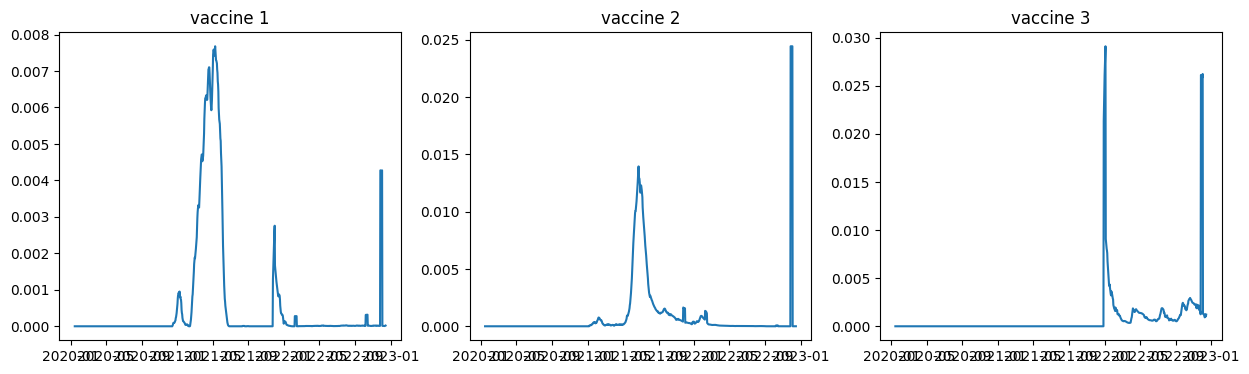

In [6]:
ground_truth_data = m2._model_data
immunity = moving_average_compare(ground_truth_data.time_series_immunity)
vaccinated1 = moving_average_compare_vaccine(ground_truth_data.time_series_vaccinated, 0)
vaccinated2 = moving_average_compare_vaccine(ground_truth_data.time_series_vaccinated, 1)
vaccinated3 = moving_average_compare_vaccine(ground_truth_data.time_series_vaccinated, 2)
plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1,3,1), plt.plot([Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1066)], np.mean(vaccinated1, axis=1)), plt.title('vaccine 1')
plt.subplot(1,3,2), plt.plot([Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1066)], np.mean(vaccinated2, axis=1)), plt.title('vaccine 2')
plt.subplot(1,3,3), plt.plot([Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1066)], np.mean(vaccinated3, axis=1)), plt.title('vaccine 3')
print((ground_truth_data.time_series_vaccinated).shape)

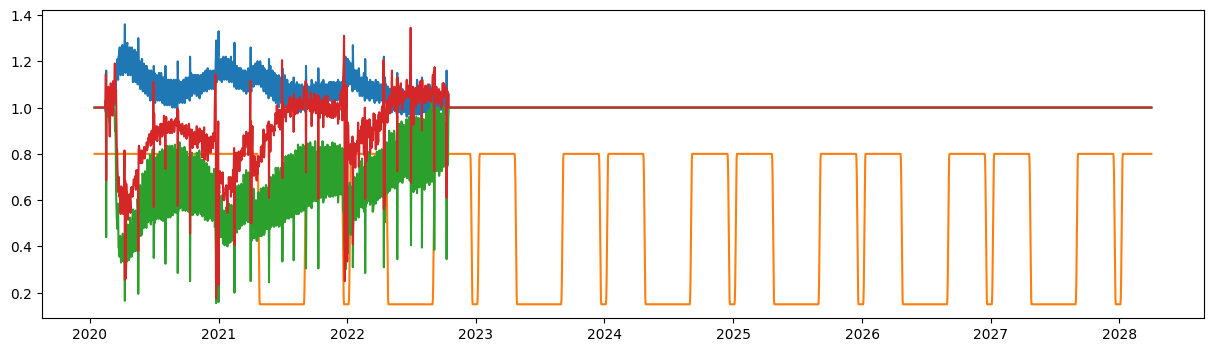

In [7]:
plt.figure(figsize=(15,4))
plt.plot([Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(3000)], m1.dependency.mobility)

### Waning kernels

(<AxesSubplot: >,
  <matplotlib.lines.Line2D at 0x1b55238e2b0>])

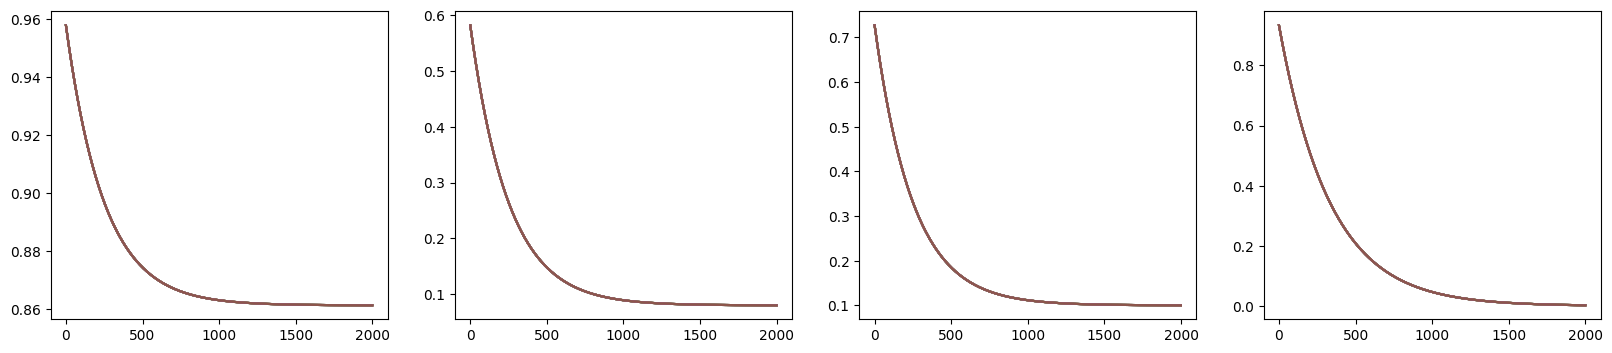

In [8]:
plt.figure(figsize=(20,4))
plt.subplot(1, 4, 1), plt.plot(Parameters.get_immunity_kernel(dose=0))
plt.subplot(1, 4, 2), plt.plot(Parameters.get_immunity_kernel(dose=1))
plt.subplot(1, 4, 3), plt.plot(Parameters.get_immunity_kernel(dose=2))
plt.subplot(1, 4, 4), plt.plot(Parameters.get_immunity_kernel(dose=3))

# Compute immunity!

In [9]:
# for i in range(1072):
#     m1._compute_immunity(i)
#     if i % 200 == 10:
#
#         x = [Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1072)]
#         for j in range(16):
#             slice = m1._model_data.time_series_immunity[0].T[j].T
#             plt.plot(x, slice, label=j)
#         plt.legend()
#         plt.xticks(rotation=45, ha='right')
#         plt.title('Predicted immunity')
#         plt.show()
#     m2.print_data(m1.date)

## Run the model

Coefficient [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
RAW_IMMUNITY [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mobility [1.2   0.15  0.36  1.005]
Coefficient [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
RAW_IMMUNITY [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mobility [1.2   0.15  0.36  1.005]
Coefficient [0.75876236 0.6126639  0.44784729 0.34302707 0.34654097 0.35048036
 0.35385491 0.35950233 0.35895297 0.36856616 0.38133006 0.39434987
 0.37672244 0.37206259 0.36006887 0.39125395]
RAW_IMMUNITY [0.24123764 0.3873361  0.55215271 0.65697293 0.65345903 0.64951964
 0.64614509 0.64049767 0.64104703 0.63143384 0.61866994 0.60565013
 0.62327756 0.62793741 0.63993113 0.60874605]
Mobility [1.19  0.15  0.415 1.   ]
Coefficient [0.75876236 0.6126639  0.44784729 0.34302707 0.34654097 0.35048036
 0.35385491 0.35950233 0.35895297 0.36856616 0.38133006 0.39434987
 0.37672244 0.37206259 0.36006887 0.39125395]
RAW_IMMUNITY [0.24123764 0.3873361  0.55215271 0.65697293 0.65345903

C:\Users\loveb\AppData\Local\Temp\ipykernel_61192\3018284949.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


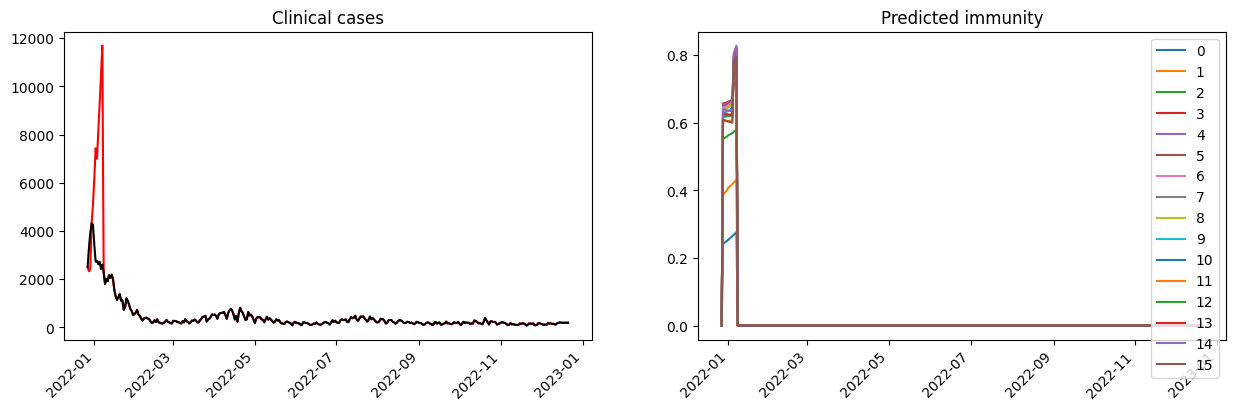

C:\Users\loveb\AppData\Local\Temp\ipykernel_61192\3018284949.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


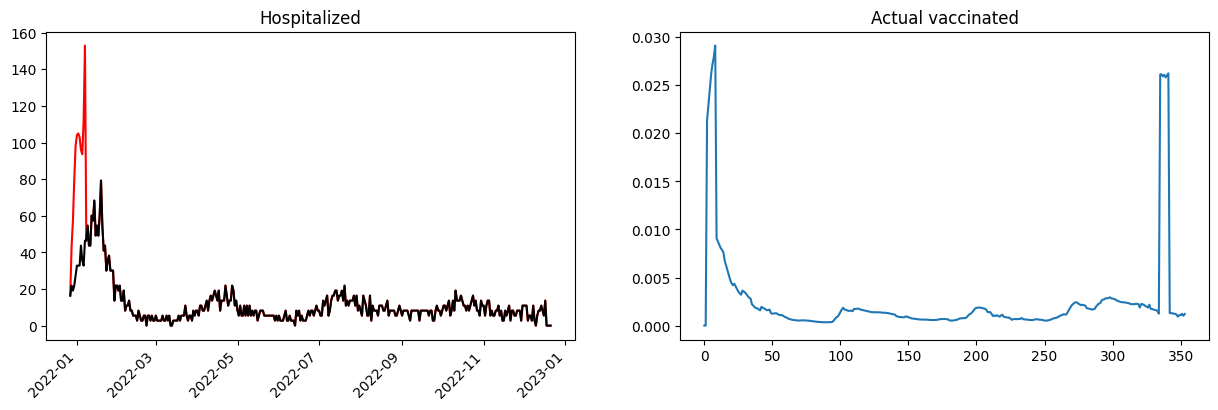

Coefficient [0.72326284 0.568916   0.42159145 0.27772166 0.21369818 0.20485183
 0.18128657 0.18045581 0.17542418 0.18286153 0.19262137 0.20300972
 0.18151184 0.17765892 0.17239862 0.20606177]
RAW_IMMUNITY [0.27673716 0.431084   0.57840855 0.72227834 0.78630182 0.79514817
 0.81871343 0.81954419 0.82457582 0.81713847 0.80737863 0.79699028
 0.81848816 0.82234108 0.82760138 0.79393823]
Mobility [1.11       0.38359375 0.675      0.83      ]
Coefficient [0.72326284 0.568916   0.42159145 0.27772166 0.21369818 0.20485183
 0.18128657 0.18045581 0.17542418 0.18286153 0.19262137 0.20300972
 0.18151184 0.17765892 0.17239862 0.20606177]
RAW_IMMUNITY [0.27673716 0.431084   0.57840855 0.72227834 0.78630182 0.79514817
 0.81871343 0.81954419 0.82457582 0.81713847 0.80737863 0.79699028
 0.81848816 0.82234108 0.82760138 0.79393823]
Mobility [1.11       0.38359375 0.675      0.83      ]
Coefficient [0.71856528 0.56396315 0.41879094 0.27287236 0.20457822 0.19417682
 0.16969134 0.1681626  0.16211603 0.16954

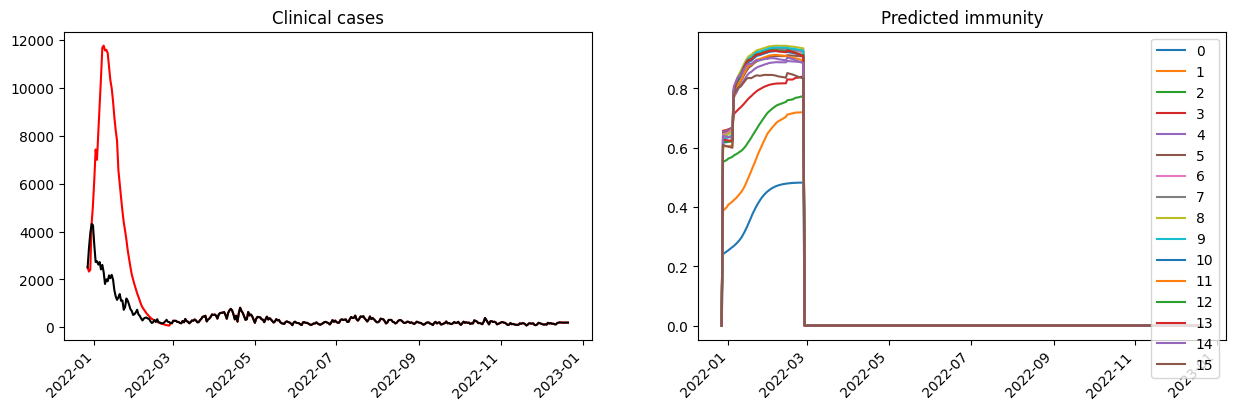

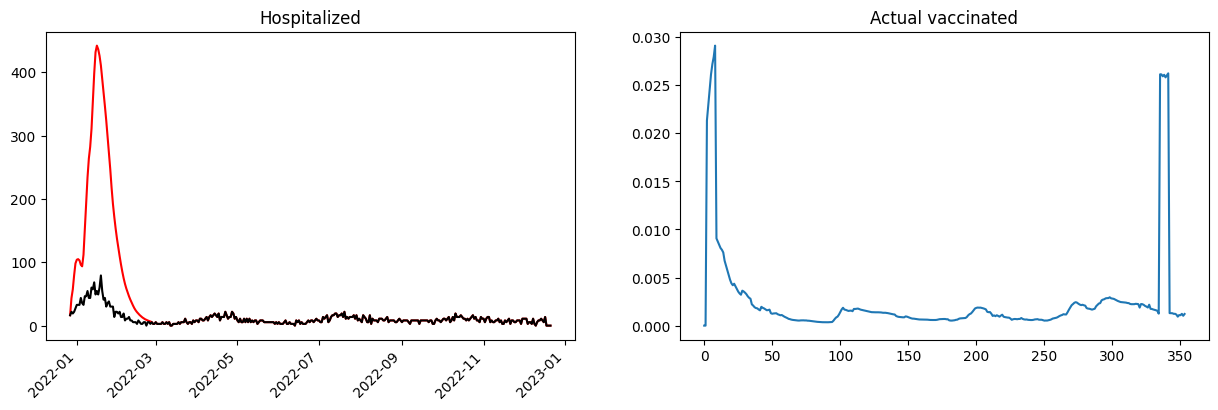

Coefficient [0.51781517 0.28043338 0.22642032 0.15978632 0.11237742 0.09291391
 0.07813424 0.07400434 0.06527555 0.07298146 0.08902014 0.10602572
 0.08872617 0.09070501 0.11478537 0.16682015]
RAW_IMMUNITY [0.48218483 0.71956662 0.77357968 0.84021368 0.88762258 0.90708609
 0.92186576 0.92599566 0.93472445 0.92701854 0.91097986 0.89397428
 0.91127383 0.90929499 0.88521463 0.83317985]
Mobility [1.04 0.8  0.77 0.9 ]
Coefficient [0.51781517 0.28043338 0.22642032 0.15978632 0.11237742 0.09291391
 0.07813424 0.07400434 0.06527555 0.07298146 0.08902014 0.10602572
 0.08872617 0.09070501 0.11478537 0.16682015]
RAW_IMMUNITY [0.48218483 0.71956662 0.77357968 0.84021368 0.88762258 0.90708609
 0.92186576 0.92599566 0.93472445 0.92701854 0.91097986 0.89397428
 0.91127383 0.90929499 0.88521463 0.83317985]
Mobility [1.04 0.8  0.77 0.9 ]
Coefficient [0.51779706 0.27961882 0.22495753 0.15829825 0.11278839 0.09334617
 0.07872218 0.07463083 0.06601347 0.07384662 0.09005591 0.1073068
 0.09036115 0.09247224 

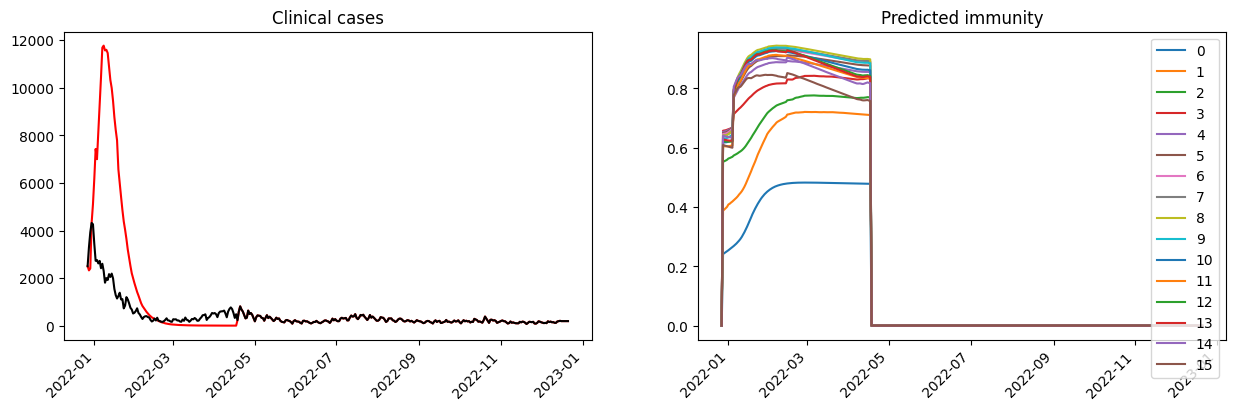

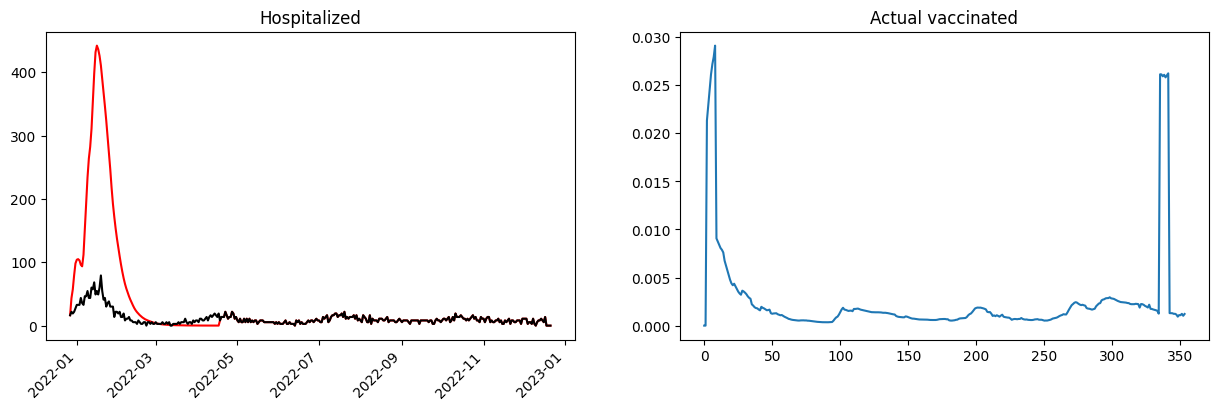

Coefficient [0.52190892 0.29007306 0.22980006 0.16619432 0.14574585 0.12352182
 0.11240001 0.10871227 0.10229616 0.11528626 0.13908251 0.16702373
 0.15795548 0.16168371 0.18255468 0.24260032]
RAW_IMMUNITY [0.47809108 0.70992694 0.77019994 0.83380568 0.85425415 0.87647818
 0.88759999 0.89128773 0.89770384 0.88471374 0.86091749 0.83297627
 0.84204452 0.83831629 0.81744532 0.75739968]
Mobility [1.13  0.8   0.505 0.915]
Coefficient [0.52190892 0.29007306 0.22980006 0.16619432 0.14574585 0.12352182
 0.11240001 0.10871227 0.10229616 0.11528626 0.13908251 0.16702373
 0.15795548 0.16168371 0.18255468 0.24260032]
RAW_IMMUNITY [0.47809108 0.70992694 0.77019994 0.83380568 0.85425415 0.87647818
 0.88759999 0.89128773 0.89770384 0.88471374 0.86091749 0.83297627
 0.84204452 0.83831629 0.81744532 0.75739968]
Mobility [1.13  0.8   0.505 0.915]
Coefficient [0.52200381 0.29060609 0.23028563 0.16679343 0.14655185 0.12424394
 0.11318868 0.10950904 0.10313401 0.11623597 0.14016987 0.16834034
 0.15949806 0.

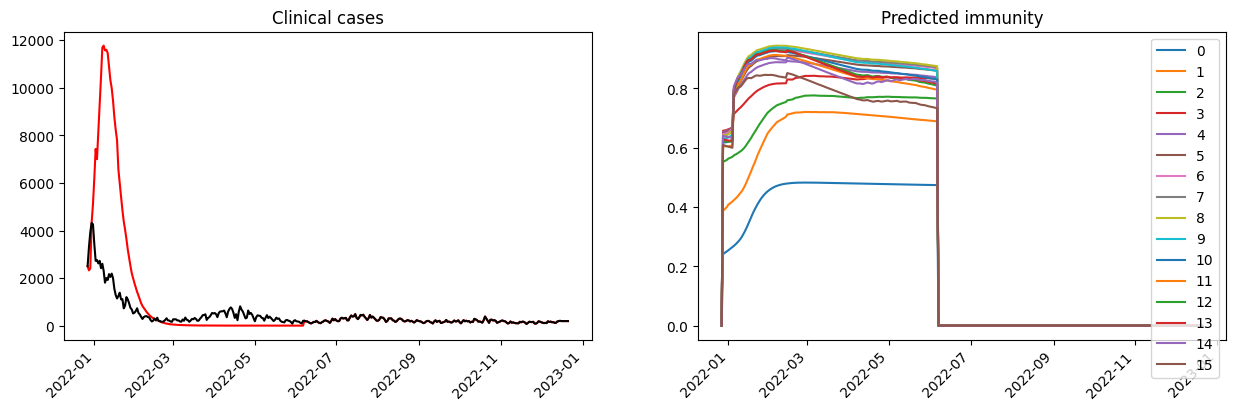

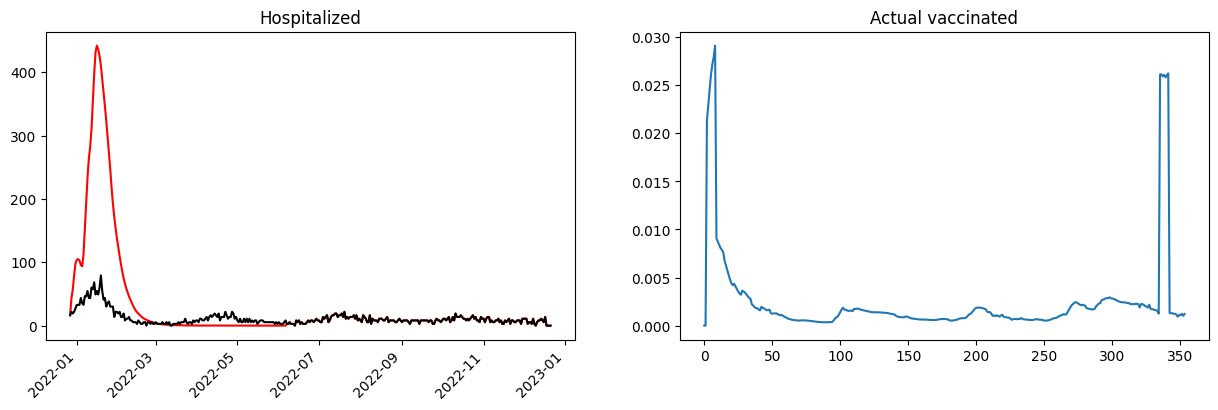

Coefficient [0.52626808 0.31127278 0.23440036 0.16822355 0.163066   0.14079789
 0.13254277 0.12892223 0.12538158 0.14145115 0.17038704 0.2050908
 0.19136574 0.18568694 0.18081502 0.26815154]
RAW_IMMUNITY [0.47373192 0.68872722 0.76559964 0.83177645 0.836934   0.85920211
 0.86745723 0.87107777 0.87461842 0.85854885 0.82961296 0.7949092
 0.80863426 0.81431306 0.81918498 0.73184846]
Mobility [1.08  0.15  0.675 1.02 ]
Coefficient [0.52626808 0.31127278 0.23440036 0.16822355 0.163066   0.14079789
 0.13254277 0.12892223 0.12538158 0.14145115 0.17038704 0.2050908
 0.19136574 0.18568694 0.18081502 0.26815154]
RAW_IMMUNITY [0.47373192 0.68872722 0.76559964 0.83177645 0.836934   0.85920211
 0.86745723 0.87107777 0.87461842 0.85854885 0.82961296 0.7949092
 0.80863426 0.81431306 0.81918498 0.73184846]
Mobility [1.08  0.15  0.675 1.02 ]
Coefficient [0.526347   0.31174969 0.23465555 0.16852795 0.16366186 0.14134395
 0.13314008 0.12951989 0.12599409 0.14213459 0.17116461 0.20604714
 0.19251784 0.1868

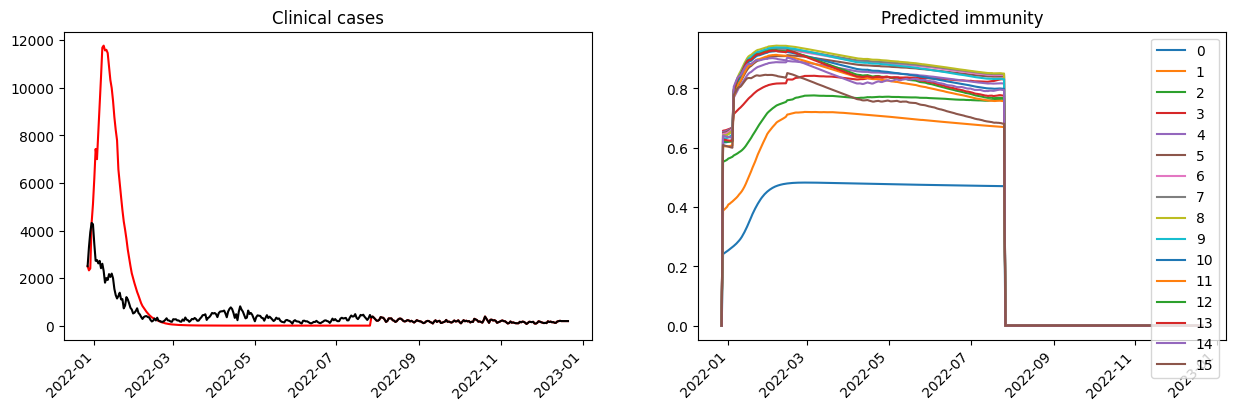

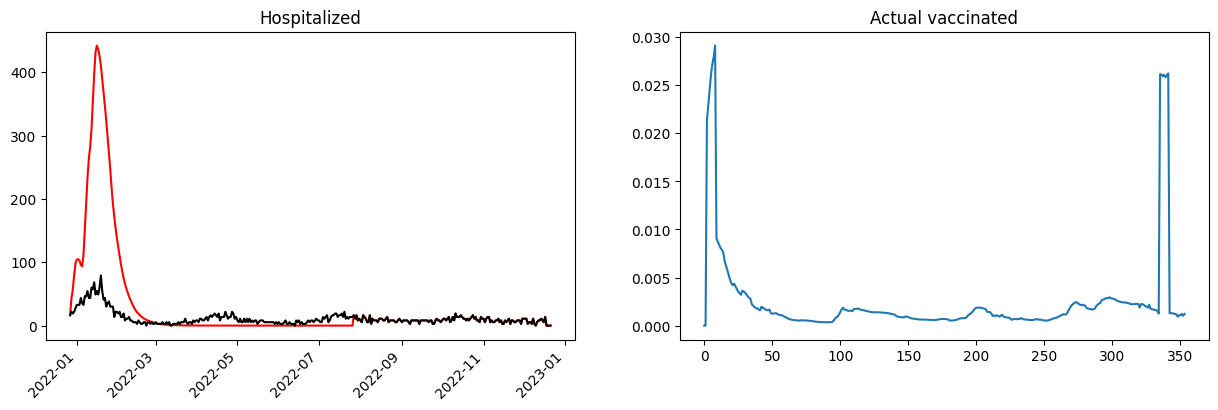

Coefficient [0.52985048 0.33060634 0.23484448 0.16871491 0.18351847 0.16055827
 0.15566035 0.1522751  0.15014359 0.16918536 0.20188801 0.24355635
 0.23387411 0.22513913 0.20606182 0.31930932]
RAW_IMMUNITY [0.47014952 0.66939366 0.76515552 0.83128509 0.81648153 0.83944173
 0.84433965 0.8477249  0.84985641 0.83081464 0.79811199 0.75644365
 0.76612589 0.77486087 0.79393818 0.68069068]
Mobility [1.07  0.15  0.675 1.075]
Coefficient [0.52985048 0.33060634 0.23484448 0.16871491 0.18351847 0.16055827
 0.15566035 0.1522751  0.15014359 0.16918536 0.20188801 0.24355635
 0.23387411 0.22513913 0.20606182 0.31930932]
RAW_IMMUNITY [0.47014952 0.66939366 0.76515552 0.83128509 0.81648153 0.83944173
 0.84433965 0.8477249  0.84985641 0.83081464 0.79811199 0.75644365
 0.76612589 0.77486087 0.79393818 0.68069068]
Mobility [1.07  0.15  0.675 1.075]
Coefficient [0.52991498 0.33092812 0.23422495 0.1678809  0.18343208 0.16054406
 0.1556582  0.15223863 0.15002892 0.16901224 0.2016963  0.24342318
 0.23380521 0.

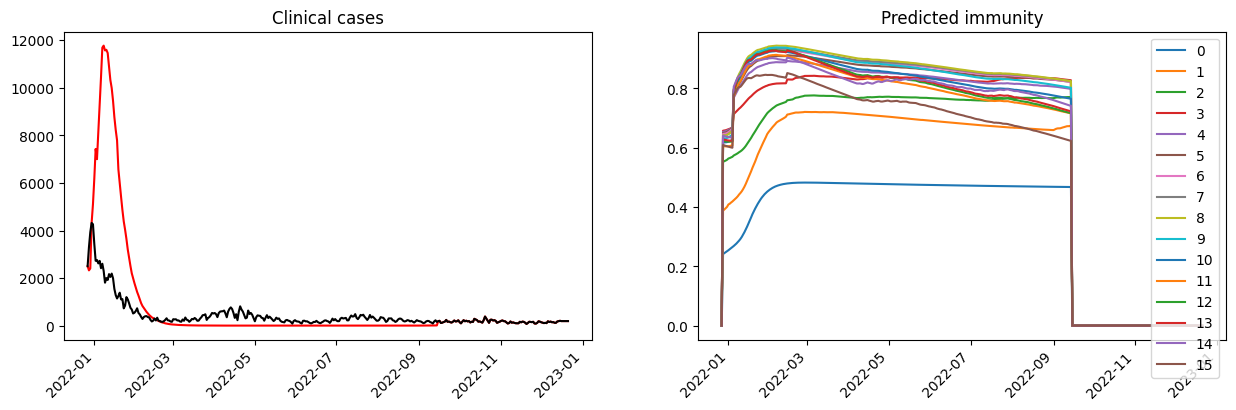

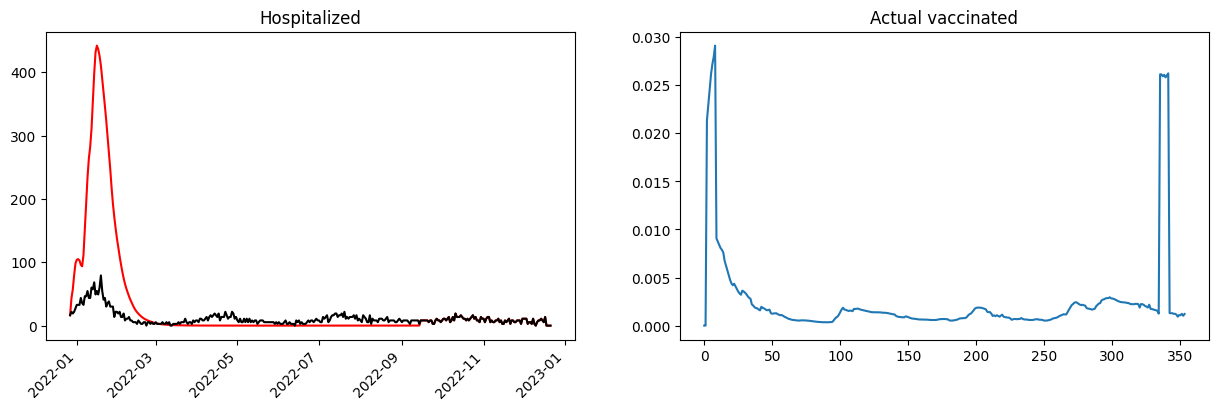

Coefficient [0.5327328  0.32554772 0.2289333  0.17286275 0.20175863 0.17836581
 0.17838361 0.17581475 0.17582572 0.19817275 0.23522201 0.28430551
 0.28382866 0.2778507  0.25875889 0.37689577]
RAW_IMMUNITY [0.4672672  0.67445228 0.7710667  0.82713725 0.79824137 0.82163419
 0.82161639 0.82418525 0.82417428 0.80182725 0.76477799 0.71569449
 0.71617134 0.7221493  0.74124111 0.62310423]
Mobility [1.05  0.8   0.76  1.065]
Coefficient [0.5327328  0.32554772 0.2289333  0.17286275 0.20175863 0.17836581
 0.17838361 0.17581475 0.17582572 0.19817275 0.23522201 0.28430551
 0.28382866 0.2778507  0.25875889 0.37689577]
RAW_IMMUNITY [0.4672672  0.67445228 0.7710667  0.82713725 0.79824137 0.82163419
 0.82161639 0.82418525 0.82417428 0.80182725 0.76477799 0.71569449
 0.71617134 0.7221493  0.74124111 0.62310423]
Mobility [1.05  0.8   0.76  1.065]
Coefficient [0.53277753 0.32385176 0.22835918 0.17327278 0.20218439 0.17875243
 0.17879562 0.17622236 0.1762324  0.19866557 0.2360714  0.28531844
 0.28466529 0.

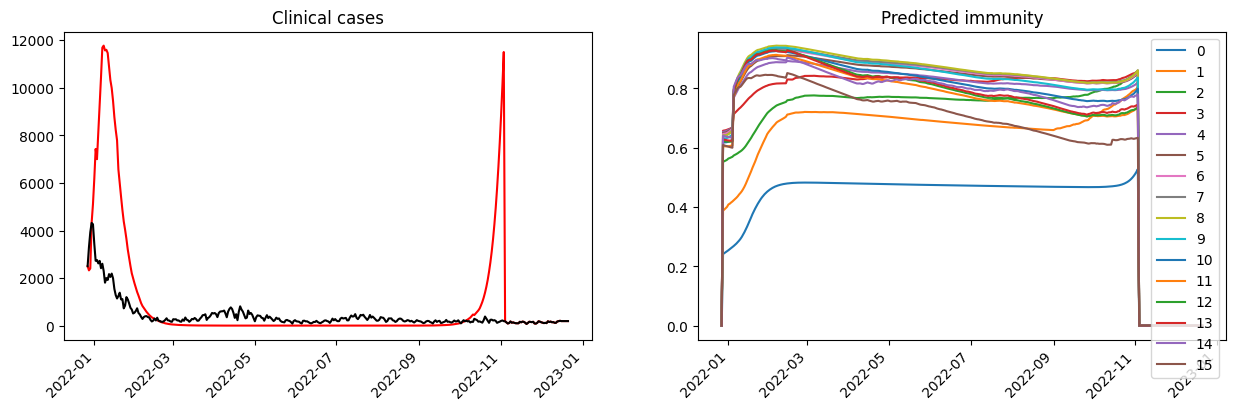

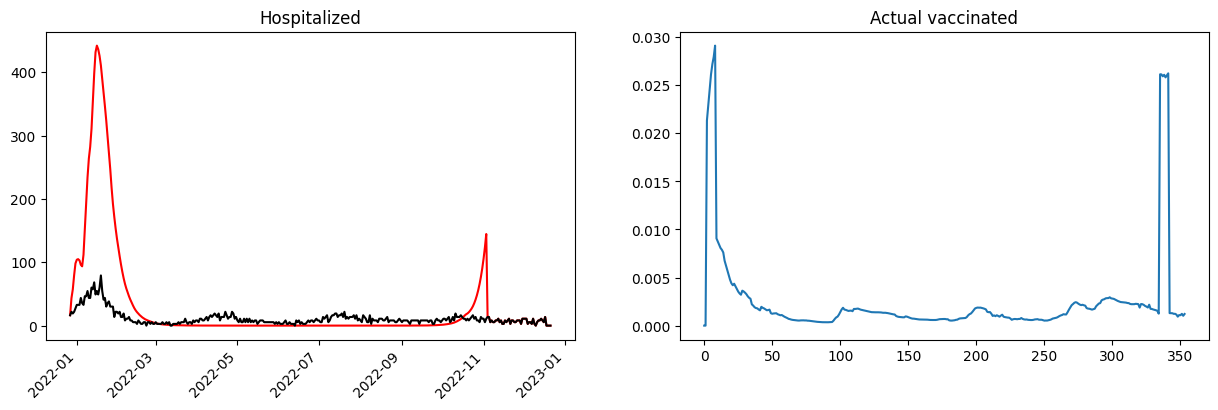

Coefficient [0.47243972 0.19663792 0.14788182 0.14143406 0.17963744 0.14814167
 0.14373688 0.13917834 0.13975194 0.16355618 0.20157314 0.26178593
 0.264691   0.25528535 0.22001946 0.3668748 ]
RAW_IMMUNITY [0.52756028 0.80336208 0.85211818 0.85856594 0.82036256 0.85185833
 0.85626312 0.86082166 0.86024806 0.83644382 0.79842686 0.73821407
 0.735309   0.74471465 0.77998054 0.6331252 ]
Mobility [1.  0.8 1.  1. ]
Coefficient [0.47243972 0.19663792 0.14788182 0.14143406 0.17963744 0.14814167
 0.14373688 0.13917834 0.13975194 0.16355618 0.20157314 0.26178593
 0.264691   0.25528535 0.22001946 0.3668748 ]
RAW_IMMUNITY [0.52756028 0.80336208 0.85211818 0.85856594 0.82036256 0.85185833
 0.85626312 0.86082166 0.86024806 0.83644382 0.79842686 0.73821407
 0.735309   0.74471465 0.77998054 0.6331252 ]
Mobility [1.  0.8 1.  1. ]
Coefficient [0.46256548 0.19215319 0.14420892 0.13786209 0.17499728 0.14229854
 0.13757307 0.13276802 0.13245746 0.15612494 0.19460377 0.25622227
 0.26072201 0.25233277 0.21861

In [10]:
for i in range(1072-m1.date-1):
    m1.run_one_cycle(display_status=False)
    if i % 50 == 10:

        x = [Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j+712) for j in range(360)]
        plt.figure(figsize=(15,4))
        plt.subplot()
        plt.subplot(1, 2, 1)
        plt.plot(x, np.sum((m1._model_data.time_series_clinical_cases[0])[712:], axis=1), color='red')
        plt.plot(x, np.sum((m2._model_data.time_series_clinical_cases[0])[712:], axis=1), color='black')
        plt.xticks(rotation=45, ha='right')
        plt.title('Clinical cases')
        plt.subplot(1, 2, 2)
        for j in range(16):
            slice = m1._model_data.time_series_immunity[0].T[j].T
            plt.plot(x, slice[712:], label=j)
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.title('Predicted immunity')
        plt.show()

        plt.figure(figsize=(15,4))
        plt.subplot()
        plt.subplot(1, 2, 1)
        plt.plot(x, np.sum((m1._model_data.time_series_hospitalized[0])[712:], axis=1), color='red')
        plt.plot(x, np.sum((m2._model_data.time_series_hospitalized[0])[712:], axis=1), color='black')
        plt.title('Hospitalized')
        plt.xticks(rotation=45, ha='right')
        plt.subplot(1, 2 ,2), plt.plot(np.mean(moving_average_compare_vaccine(m1._model_data.time_series_vaccinated, 2)[712:], axis=1)), plt.title('vaccine 3')
        plt.title('Actual vaccinated')
        plt.show()
    # m2.print_data(m1.date)

In [11]:
predicated_data = m1._model_data
ground_truth_clinical = moving_average_compare(m2._model_data.time_series_clinical_cases)
predicted_clinical = moving_average_compare(predicated_data.time_series_clinical_cases)
print(compute_sdd(ground_truth_clinical, predicted_clinical))

742745398.3289034


C:\Users\loveb\AppData\Local\Temp\ipykernel_61192\3150817106.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1), plt.plot(x, ground_truth_clinical)


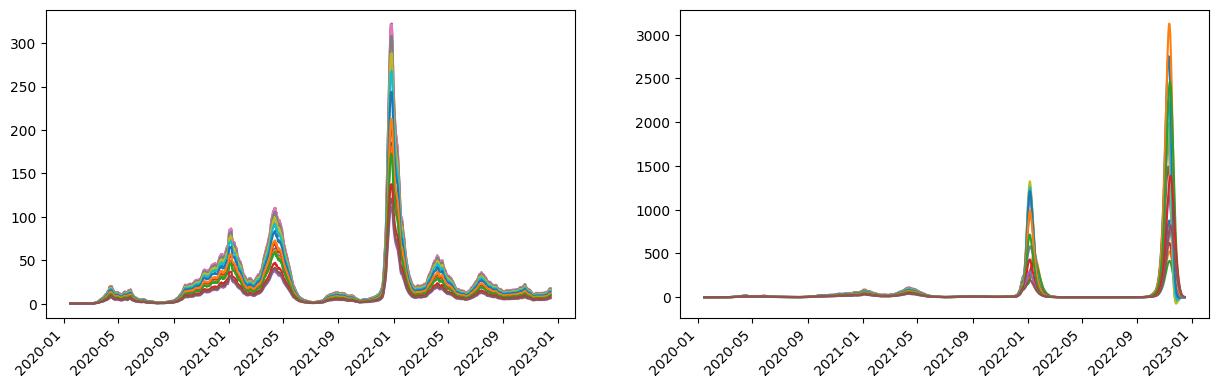

In [12]:
x = [Parameters.OUTBREAK_FIRST_DAY + datetime.timedelta(days=j) for j in range(1066)]

plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1, 2, 1), plt.plot(x, ground_truth_clinical)
plt.xticks(rotation=45, ha='right')
plt.subplot(1, 2, 2), plt.plot(x, predicted_clinical)
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
ground_truth_deaths = moving_average_compare(m2._model_data.time_series_deaths)
predicted_deaths = moving_average_compare(m1._model_data.time_series_deaths)
print(compute_sdd(ground_truth_deaths, predicted_deaths))

136284.7665054627


C:\Users\loveb\AppData\Local\Temp\ipykernel_61192\1393902282.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1), plt.plot(ground_truth_deaths)


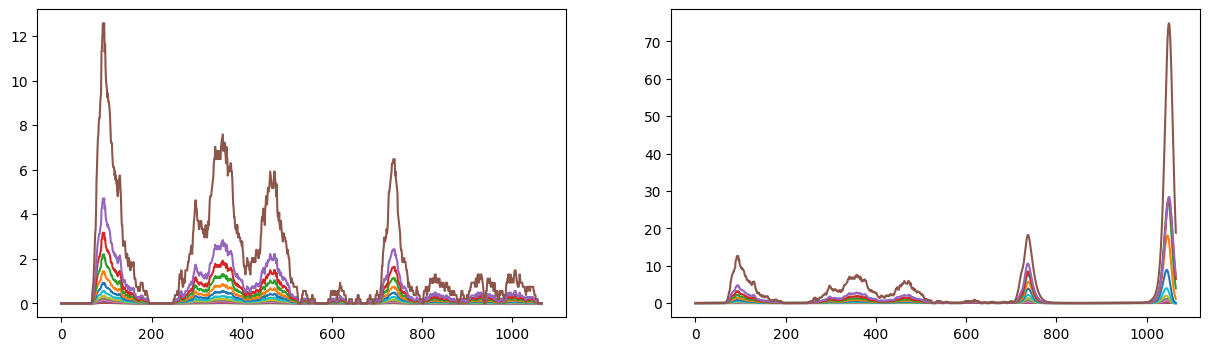

In [14]:
plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1, 2, 1), plt.plot(ground_truth_deaths)
plt.subplot(1, 2, 2), plt.plot(predicted_deaths)
plt.show()

In [15]:
ground_truth_hosp = moving_average_compare(m2._model_data.time_series_hospitalized)
predicted_hosp = moving_average_compare(m1._model_data.time_series_hospitalized)
print(compute_sdd(ground_truth_hosp, predicted_hosp))

2351450.9741097423


C:\Users\loveb\AppData\Local\Temp\ipykernel_61192\4159675980.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1), plt.plot(ground_truth_hosp)


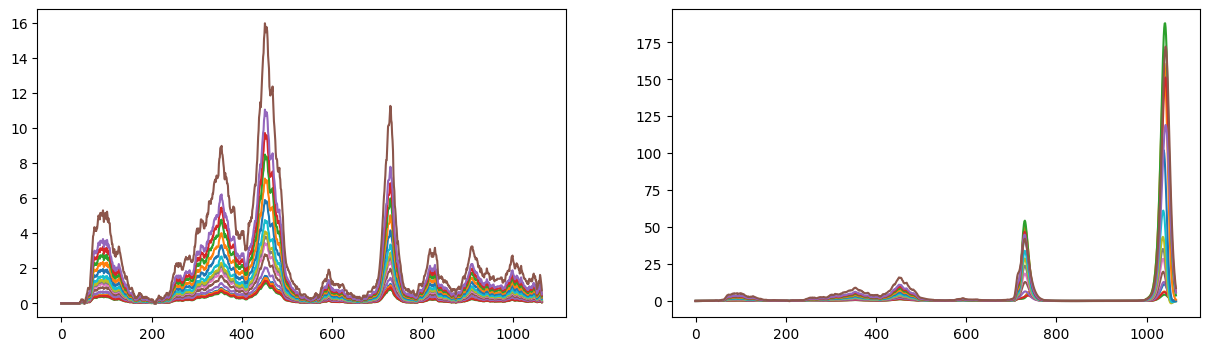

In [16]:
plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1, 2, 1), plt.plot(ground_truth_hosp)
plt.subplot(1, 2, 2), plt.plot(predicted_hosp)
plt.show()

In [17]:
ground_truth_icu = moving_average_compare(m2._model_data.time_series_ICU)
predicted_icu = moving_average_compare(m1._model_data.time_series_ICU)
print(compute_sdd(ground_truth_icu, predicted_icu))

101468.79288512895


C:\Users\loveb\AppData\Local\Temp\ipykernel_61192\3259189337.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1), plt.plot(ground_truth_icu)


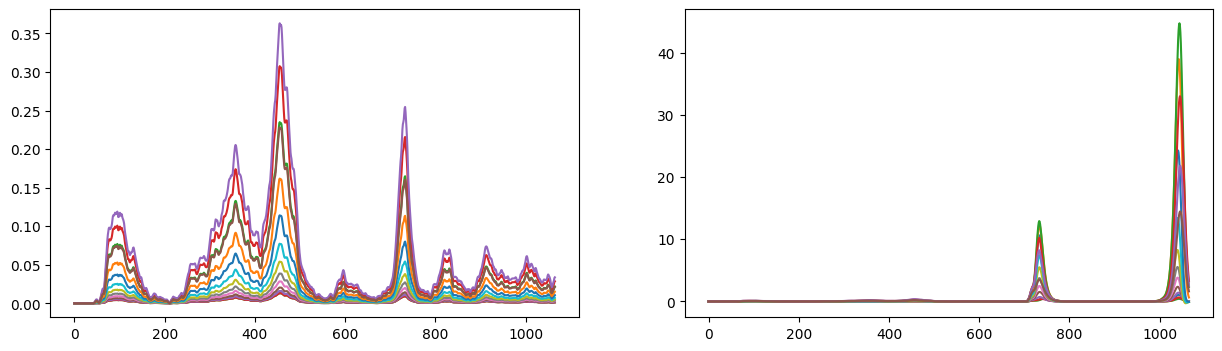

In [18]:
plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1, 2, 1), plt.plot(ground_truth_icu)
plt.subplot(1, 2, 2), plt.plot(predicted_icu)
plt.show()

In [19]:
print(np.sum(m2._model_data.time_series_deaths))

14192.330358999987


C:\Users\loveb\AppData\Local\Temp\ipykernel_61192\1890786805.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1), plt.plot(immunity)


(<AxesSubplot: >,
  <matplotlib.lines.Line2D at 0x1b5524128e0>])

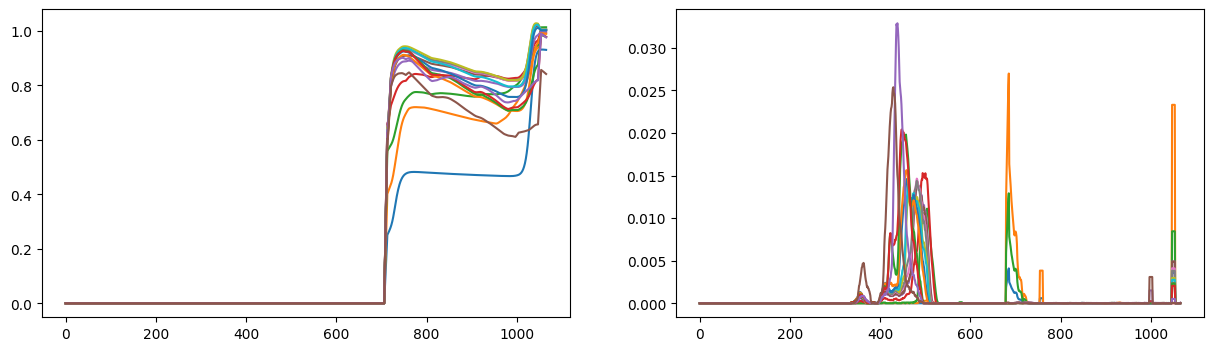

In [20]:
immunity = moving_average_compare(m1._model_data.time_series_immunity)
vaccine = moving_average_compare(m1._model_data.time_series_vaccinated)
plt.figure(figsize=(15,4))
plt.subplot()
plt.subplot(1, 2, 1), plt.plot(immunity)
plt.subplot(1, 2, 2), plt.plot(vaccine)

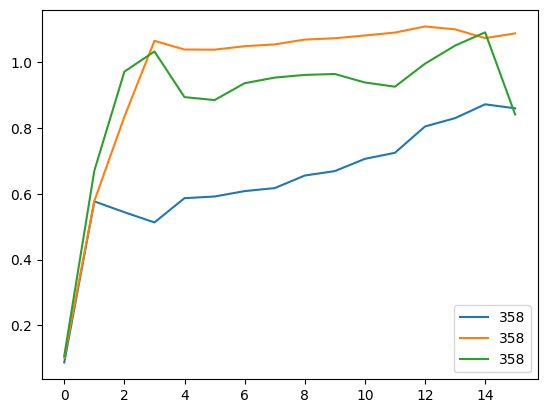

In [21]:

plt.plot(np.sum(m1._model_data.time_series_vaccinated[0], axis=0).T, label=i)
plt.plot(np.sum(m1._model_data.time_series_vaccinated[1], axis=0).T, label=i)
plt.plot(np.sum(m1._model_data.time_series_vaccinated[2], axis=0).T, label=i)
plt.legend()
plt.show()

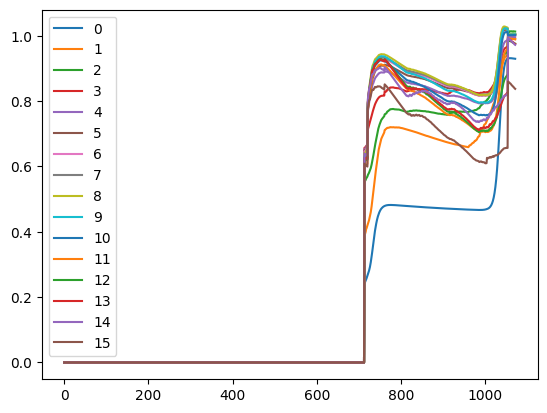

In [22]:
for i in range(16):
    slice = m1._model_data.time_series_immunity[0].T[i].T
    plt.plot(slice, label=i)
plt.legend()
plt.show()

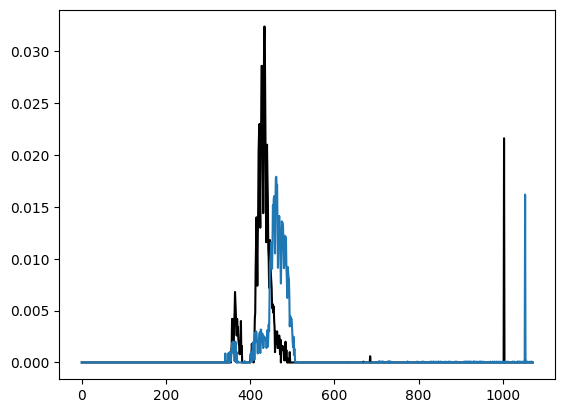

In [23]:

slice = m1._model_data.time_series_vaccinated[0].T[15].T
plt.plot(slice, color='black')
slice = m1._model_data.time_series_vaccinated[0].T[14].T
slice = m1._model_data.time_series_vaccinated[0].T[13].T
slice = m1._model_data.time_series_vaccinated[0].T[12].T
slice = m1._model_data.time_series_vaccinated[0].T[11].T
plt.plot(slice)
plt.show()

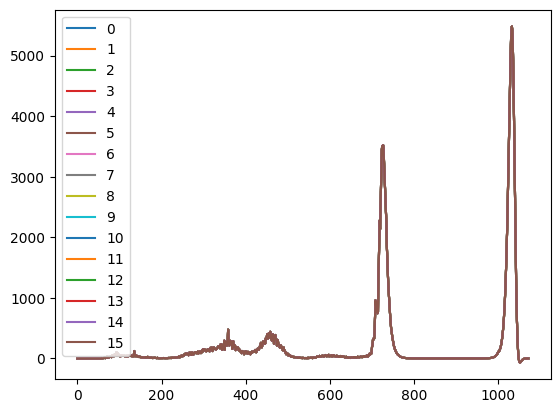

In [24]:
for i in range(16):
    slice = m1._model_data.time_series_active_cases[0].T[5].T
    plt.plot(slice, label=i)
plt.legend()
plt.show()

In [25]:
m1.save_to_file()

['Toronto Public Health', 'Ottawa Public Health', 'Peel Public Health', 'City of Hamilton Public Health Services', 'Middlesex-London Health Unit', 'York Region Public Health', 'Region of Waterloo Public Health and Emergency Services', 'Windsor-Essex County Health Unit ', 'Halton Region Public Health', 'Public Health Sudbury & Districts', 'Durham Region Health Department ', 'Simcoe Muskoka District Health Unit ', 'Niagara Region Public Health', 'Wellington-Dufferin-Guelph Public Health', 'Kingston, Frontenac and Lennox & Addington Public Health', 'Thunder Bay District Health Unit', 'Chatham-Kent Public Health', 'Brant County Health Unit', 'Peterborough Public Health ', 'Haliburton, Kawartha, Pine Ridge District Health Unit ', 'Algoma Public Health', 'Lambton Public Health', 'North Bay Parry Sound District Health Unit', 'Hastings Prince Edward Public Health', 'Eastern Ontario Health Unit', 'Porcupine Health Unit', 'Southwestern Public Health', 'Huron Perth Health Unit', 'Leeds, Grenville